!pip install wordcloud
!pip install keras

In [1]:
!pip install keras

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import string
import spacy
import keras


from spacy.lang.en import English
from spacy.tokens import Doc
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM


import wordcloud
from wordcloud import WordCloud,ImageColorGenerator

#LinearSVC,Logistic Regression,RandomForest,DecisionTree,KNeighborsClassifier
# Can use Distilbert https://towardsdatascience.com/use-pre-trained-huggingface-models-in-tensorflow-serving-d2761f7e69f6


In [3]:
wsb = pd.read_csv('/Users/jeremiahkamama/Desktop/Article Projects/Spacy-Analysis/data/reddit_wsb.csv')

wsb.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [4]:
wsb.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38641 entries, 0 to 38640
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      38641 non-null  object 
 1   score      38641 non-null  int64  
 2   id         38641 non-null  object 
 3   url        38641 non-null  object 
 4   comms_num  38641 non-null  int64  
 5   created    38641 non-null  float64
 6   body       19244 non-null  object 
 7   timestamp  38641 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.4+ MB


In [5]:
#handling missing data
miss_val = wsb.isnull().sum()

miss_val[0:10]

title            0
score            0
id               0
url              0
comms_num        0
created          0
body         19397
timestamp        0
dtype: int64

In [6]:
cells = np.product(wsb.shape)
missing = miss_val.sum()

percentage_miss = (missing/cells)* 100

print(percentage_miss)

6.274747030356358


In [7]:
wsb.dropna()

,title,score,id,url,comms_num,created,body,timestamp
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,l6uf6d,https://www.reddit.com/r/wallstreetbets/commen...,53,1.611862e+09,Hedgefund whales are spreading disinfo saying ...,2021-01-28 21:26:27
7,THIS IS THE MOMENT,405,l6ub9l,https://www.reddit.com/r/wallstreetbets/commen...,178,1.611862e+09,Life isn't fair. My mother always told me that...,2021-01-28 21:19:31
10,"We need to keep this movement going, we all ca...",222,l6uao1,https://www.reddit.com/r/wallstreetbets/commen...,70,1.611862e+09,I believe right now is one of those rare oppo...,2021-01-28 21:18:25
12,"Once you're done with GME - $AG and $SLV, the ...",0,l6u9wu,https://www.reddit.com/r/wallstreetbets/commen...,16,1.611861e+09,You guys are champs. GME... who would have tho...,2021-01-28 21:17:10
...,...,...,...,...,...,...,...,...
38622,What Have I to Lose?!?!?!!? GME 2 MOON,130,lwx3sr,https://www.reddit.com/r/wallstreetbets/commen...,13,1.614816e+09,&#x200B;\n\nhttps://preview.redd.it/hexuezcw4u...,2021-03-04 01:54:44
38624,RKT and Morgan Stanley Discussion - My notes f...,105,lwx1e9,https://www.reddit.com/r/wallstreetbets/commen...,72,1.614816e+09,RKT as a tech platform / real estate doubled a...,2021-03-04 01:51:52
38626,$VG - Vonage Invester Day on Friday,18,lwwsq8,https://www.reddit.com/r/wallstreetbets/commen...,11,1.614815e+09,Vonage is the 2nd largest UCaaS (Unified Commu...,2021-03-04 01:41:49
38631,Old School Mentality... still holding GME. Why...,296,lwwoc4,https://www.reddit.com/r/wallstreetbets/commen...,46,1.614815e+09,"I don't know if I am an Ape, Autist or Retard....",2021-03-04 01:36:29


In [8]:
wsb.drop(columns=['id'])

,title,score,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56
...,...,...,...,...,...,...,...
38636,NCLH 💎🙌🚀🌕 YOLO update!!!,19,https://i.redd.it/v0k8a7s00uk61.png,5,1.614814e+09,NaN,2021-03-04 01:27:07
38637,Adding to $RKT 300 more to 1000 on morning pul...,59,https://i.redd.it/z0k1zy3nytk61.jpg,76,1.614814e+09,NaN,2021-03-04 01:19:25
38638,Started at 5k a few weeks ago. Now it’s time f...,44,https://i.redd.it/ih9442fkytk61.jpg,26,1.614814e+09,NaN,2021-03-04 01:19:01
38639,Posted yesterday about buying GME 104 @ $122.9...,864,https://i.redd.it/mor1g3z9ytk61.jpg,22,1.614813e+09,NaN,2021-03-04 01:17:22


In [9]:
nlp = spacy.load("en_core_web_sm")

In [10]:
wsb_title = wsb['title'].dropna()

wsb_title = wsb_title.head(10)
print(wsb_title)

0    It's not about the money, it's about sending a...
1    Math Professor Scott Steiner says the numbers ...
2                                      Exit the system
3    NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
4    Not to distract from GME, just thought our AMC...
5                                  WE BREAKING THROUGH
6          SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE
7                                   THIS IS THE MOMENT
8    Currently Holding AMC and NOK - Is it retarded...
9    I have nothing to say but BRUH I am speechless...
Name: title, dtype: object


In [11]:
title = nlp(wsb_title[1])
print(title)

Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts


In [12]:
for token in title:
    print(token.text,token.pos_,token.dep_)

Math PROPN compound
Professor PROPN compound
Scott PROPN compound
Steiner PROPN nsubj
says VERB ROOT
the DET det
numbers NOUN nsubj
spell VERB ccomp
DISASTER NOUN dobj
for ADP prep
Gamestop PROPN compound
shorts NOUN pobj


In [13]:
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']


In [14]:
wsb_body = wsb['body'].dropna()
wsb_body = wsb_body.head()
print(wsb_body)

2     The CEO of NASDAQ pushed to halt trading “to g...
6     Hedgefund whales are spreading disinfo saying ...
7     Life isn't fair. My mother always told me that...
10     I believe right now is one of those rare oppo...
12    You guys are champs. GME... who would have tho...
Name: body, dtype: object


In [15]:
body_wsb = wsb_body[2]
print(body_wsb)

The CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibrate their positions”.

[https://mobile.twitter.com/Mediaite/status/1354504710695362563](https://mobile.twitter.com/Mediaite/status/1354504710695362563)

Now SEC is investigating, brokers are disallowing buying more calls. This is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing Uber on the side?”

We may have collectively driven up enough sentiment in wall street to make other big players go long on GME with us (we do not have the money to move the stock as much as it did alone). we didn’t hurt wall street as a whole, just a few funds went down while others went up and profited off the shorts the same as us. The media wants to pin the blame on us.

It should be crystal clear that this is a rigged game by now. Its time to build

In [16]:


def clean_text_date(text):
    text = text.lower()

    # Replacing Handlers with Empty String
    text = re.sub('@[^\s]+','',text)

    # Replacing URLs with Empty String
    text = re.sub(r"http\S+", "",text)

    # Remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # Replacing Single Characters with Empty String
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Removing Extra Spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text
 

In [17]:
body = clean_text(body_wsb)
print(body)

NameError: name 'clean_text' is not defined

In [42]:
body_wsb = nlp(body)
print(body_wsb)

the ceo of nasdaq pushed to halt trading to give investors chance to recalibrate their positions now sec is investigating brokers are disallowing buying more calls this is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us we get well shucks you should have known investing is risky have you tried cutting out avocados and coffee maybe doing uber on the side we may have collectively driven up enough sentiment in wall street to make other big players go long on gme with us we do not have the money to move the stock as much as it did alone we didn hurt wall street as whole just few funds went down while others went up and profited off the shorts the same as us the media wants to pin the blame on us it should be crystal clear that this is rigged game by now its time to build new exchanges that can arbitrarily change the rules on us cr has some version of these maybe they can be repurposed to be trade stock without government intervent

In [44]:
token_list = []

for token in body_wsb:
    token_list.append(token.text)

filter_sentence = []

for word in token_list:
    lexeme = nlp.vocab[word]
    if lexeme.is_stop == False:
        filter_sentence.append(word)

print(token_list)


['the', 'ceo', 'of', 'nasdaq', 'pushed', 'to', 'halt', 'trading', 'to', 'give', 'investors', 'chance', 'to', 'recalibrate', 'their', 'positions', 'now', 'sec', 'is', 'investigating', 'brokers', 'are', 'disallowing', 'buying', 'more', 'calls', 'this', 'is', 'the', 'institutions', 'flat', 'out', 'admitting', 'they', 'will', 'change', 'the', 'rules', 'to', 'bail', 'out', 'the', 'rich', 'but', 'if', 'it', 'happens', 'to', 'us', 'we', 'get', 'well', 'shucks', 'you', 'should', 'have', 'known', 'investing', 'is', 'risky', 'have', 'you', 'tried', 'cutting', 'out', 'avocados', 'and', 'coffee', 'maybe', 'doing', 'uber', 'on', 'the', 'side', 'we', 'may', 'have', 'collectively', 'driven', 'up', 'enough', 'sentiment', 'in', 'wall', 'street', 'to', 'make', 'other', 'big', 'players', 'go', 'long', 'on', 'gme', 'with', 'us', 'we', 'do', 'not', 'have', 'the', 'money', 'to', 'move', 'the', 'stock', 'as', 'much', 'as', 'it', 'did', 'alone', 'we', 'didn', 'hurt', 'wall', 'street', 'as', 'whole', 'just', '

In [45]:
print(filter_sentence)

['ceo', 'nasdaq', 'pushed', 'halt', 'trading', 'investors', 'chance', 'recalibrate', 'positions', 'sec', 'investigating', 'brokers', 'disallowing', 'buying', 'calls', 'institutions', 'flat', 'admitting', 'change', 'rules', 'bail', 'rich', 'happens', 'shucks', 'known', 'investing', 'risky', 'tried', 'cutting', 'avocados', 'coffee', 'maybe', 'uber', 'collectively', 'driven', 'sentiment', 'wall', 'street', 'big', 'players', 'long', 'gme', 'money', 'stock', 'didn', 'hurt', 'wall', 'street', 'funds', 'went', 'went', 'profited', 'shorts', 'media', 'wants', 'pin', 'blame', 'crystal', 'clear', 'rigged', 'game', 'time', 'build', 'new', 'exchanges', 'arbitrarily', 'change', 'rules', 'cr', 'version', 'maybe', 'repurposed', 'trade', 'stock', 'government', 'intervention', 'don', 'know', 'exactly', 'look', 'like', 'broad', 'steps', '1', 'exit', 'current', 'financial', 'system', '2', 'build', 'new']


In [46]:
desc_stopwords = set(STOP_WORDS)

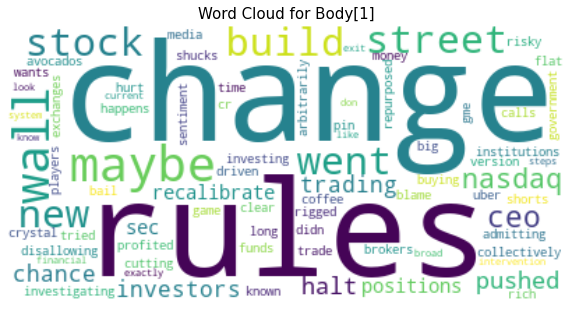

In [47]:
word_cloud = WordCloud(background_color="white", stopwords=desc_stopwords).generate(body)

plt.figure(figsize=(10,20))
plt.imshow(word_cloud,interpolation= 'bilinear')
plt.title("Word Cloud for Body[1]",fontsize=15)
plt.axis("off")
plt.show()


In [54]:
def train_model(
    model = Sequential()
      model.add(Embedding(max_features)),
    model.add(Dense(2,activation='softmax')),
    model.compile(loss='categorical_crossentropy',optimizer='adam',metric =['accuracy'])

)




SyntaxError: invalid syntax (<ipython-input-54-a2f45b22f54b>, line 3)